# Real-Time Optimization Tutorial
## Williams-Otto reactor system

In [ ]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from bunch import Bunch

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
#logging.basicConfig(level=logging.DEBUG)

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform, generate_samples_lhs
from rto.experiment.analysis import ExperimentAnalyzer

MEMORY_DATABASE = "file::memory:?cache=shared"

## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [ ]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [ ]:
# Define the input domain
grid_size = 50
g0 = 0.12
g1 = 0.08

u1 = np.linspace(3, 6, grid_size)
u2 = np.linspace(70, 100, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g[:,0].reshape(xx.shape)
    zz_g1 = g[:,1].reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

z_plant, g0_plant, g1_plant = get_grid_values(plant, xx, yy)
z_model, g0_model, g1_model = get_grid_values(model, xx, yy)
g_plant = (g1_plant < g1)&(g0_plant < g0)
g_model = (g1_model < g1)&(g0_model < g0)

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

In [ ]:
# Plot the decision surface
fig, ax = plt.subplots(1, 2, figsize=(12,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title):
    ax.contour(xx, yy, z_f, colors='red')
    CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

plot_decision_surface(fig, ax[0], xx, yy, g_plant, z_plant, 'Plant')
plot_decision_surface(fig, ax[1], xx, yy, g_model, z_model, 'Model')
fig.show()

From this chart we notice these interesting information:
1. The unconstrained minima of plant and model and very different. Optimizing over the model would definitely result in a sub-optimal operating point.
2. When constraints are added, the optima are located at their intersection. This could lead to unfeasible operation if optimazing over the model, if not properly evaluated beforehand.

Let's have a deeper look at item (2). In order to do that, we should solve the optimization problem described previously, for both the plant and model. The Differential Evolution algorithm will be used, because of it's nice capabilities for handling restrictions and global convergence.

In [ ]:
ubx = [6, 100]
lbx = [3, 70]
g = np.array([g0, g1])

optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}}, backoff=0.0)
f_plant, u_plant ,_ = optimizer.run(plant, [])
f_model, u_model ,_ = optimizer.run(model, [])

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Although the solution found for both the model and plant are very close, let's see what happens if we apply the input found with the model into the plant. The 'x' represents the model solution, while the "*" the plant optimum.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
model_cost = plant.get_objective(u_model)

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.scatter(u_model[0], u_model[1], c='w', marker='x', s=150, zorder=5)
fig.show()

Notice that although the solution remained inside the feasible region, it is definitely sub-optimal. It is easy to notice that depending on the model parameters, the optimal solution could easily become unfeasible. Thus, one can see that some sort of adaptation of the model is necessary to ensure convergence to the actual plant optimum, while respecting the process constraints. 

In [ ]:
# creates a memory database to be used in this tutorial
!python ../scripts/create_database.py -m

In [ ]:
# Define the system parameters
u_0 = u_model
iterations = 30
noise = 0.01
initial_data_size = 5

# sample some initial data
u, y, measurements = generate_samples_uniform(model, plant, g, u_0, initial_data_size, noise=noise)
initial_data = Bunch(u=u, y=y, measurements=measurements)

# create the adaptation strategy
adaptation = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
optimizer_ma = ModifierAdaptationOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de'}, backoff=0.0)

adaptation_bay = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
optimizer_bay = ModelBasedBayesianOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de'}, backoff=0.0)

# func_bay = optimizer_bay._get_eic_function(model, adaptation_bay, f_best)

rto = RTO(model, plant, optimizer_ma, adaptation, iterations, db_file=MEMORY_DATABASE, name='MA-GP', noise=noise)
rto_bay = RTOBayesian(model, plant, optimizer_bay, adaptation_bay, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian', noise=noise)

Finally, we can run the RTO system. The last sampled initial operating point is used to start the system.

In [ ]:
u_0_feas = u[-1]
for i in range(15):
    rto_bay.run(u_0_feas)
    rto.run(u_0_feas)

In [59]:
# load the results
analyzer = ExperimentAnalyzer(MEMORY_DATABASE)
results = analyzer.load('MA-GP')
results_tr = analyzer.load('MA-GP-Bayesian')

results_processed = analyzer.pre_process(results, f_plant, u_plant)
results_processed_tr = analyzer.pre_process(results_tr, f_plant, u_plant)

results_all = pd.concat([results_processed, results_processed_tr], ignore_index=True)

Below the results for the cost and input optimality gap are displayed. Notice that, although starting from some random initial points, the RTO system was able to drive the process towards plant optimality (0% gap), even though we use an approximate model and measurements are noisy.

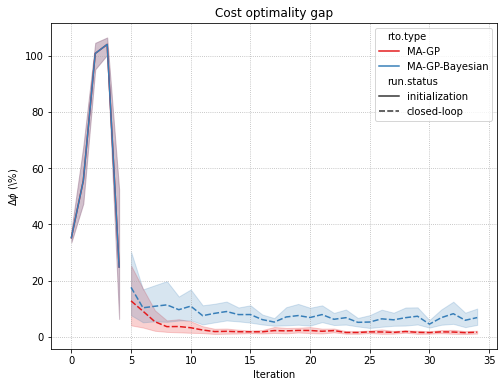

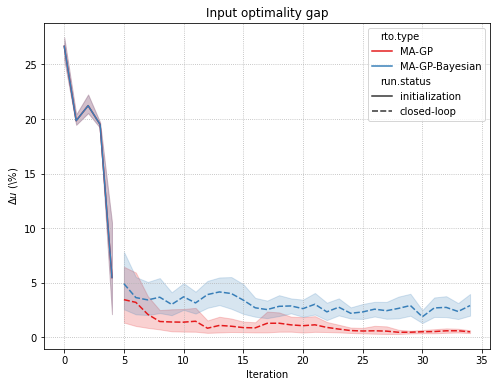

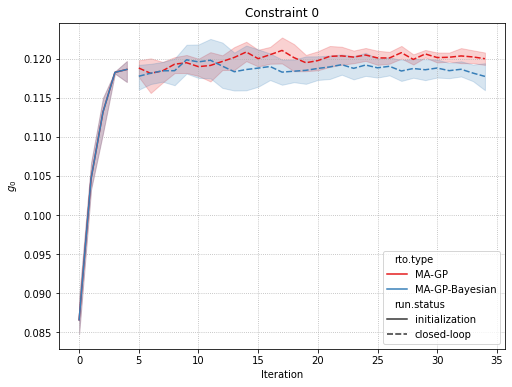

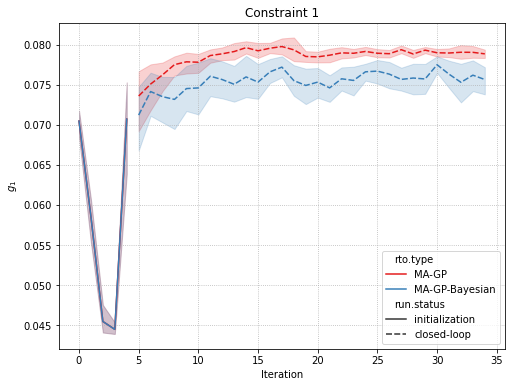

In [60]:
_ = analyzer.plot_by_iteration(results_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

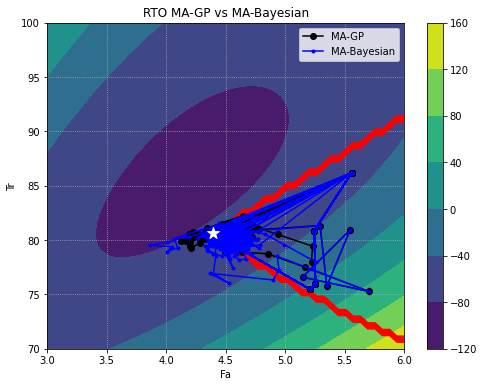

In [61]:
fig, ax = plt.subplots(figsize=(8,6))

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, 'RTO MA-GP vs MA-Bayesian')
u_rto = np.stack(results_processed['u'], axis=0)
u_rto_init = u_rto[:initial_data_size, :]
u_rto = u_rto[initial_data_size:, :]

u_rto_tr = np.stack(results_processed_tr['u'], axis=0)
u_rto_init_tr = u_rto_tr[:initial_data_size, :]
u_rto_tr = u_rto_tr[initial_data_size:, :]

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
ax.plot(u_rto_init[:,0], u_rto_init[:,1], 'md', zorder=4)
line1, = ax.plot(u_rto[:,0], u_rto[:,1], 'ko-', zorder=4)
line2, = ax.plot(u_rto_tr[:,0], u_rto_tr[:,1], 'b.-', zorder=5)

ax.legend((line1, line2), ('MA-GP','MA-Bayesian'))

fig.show()

In [ ]:
gp_iterations = [analyzer.load_run_models(run_id) for run_id in results_processed['run.id']]
gp_iterations_bayes = [analyzer.load_run_models(run_id) for run_id in results_processed_tr['run.id']]

In [ ]:
def get_grid_predictions(models, xx, yy):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x) + fobj.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_0 = np.array([model.get_constraints(x)[0] + constraint0.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_1 = np.array([model.get_constraints(x)[1] + constraint1.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g_0.reshape(xx.shape)
    zz_g1 = g_1.reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

In [ ]:
def plot_gp_surface(fig, ax, xx, yy, z_f, title):
    CS = ax.contourf(xx, yy, z_f)
    #CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

# fig, ax = plt.subplots(2, 2, figsize=(12,6))
# fobj_pred_first,_,_ = get_grid_predictions(gp_iterations[5],xx,yy)
# fobj_pred_mid1,_,_ = get_grid_predictions(gp_iterations[15],xx,yy)
# fobj_pred_mid2,_,_ = get_grid_predictions(gp_iterations[30],xx,yy)
# fobj_pred_last,_,_ = get_grid_predictions(gp_iterations[-1],xx,yy)

# plot_gp_surface(fig, ax[0,0], xx, yy, fobj_pred_first, f'GP mean - first')
# plot_gp_surface(fig, ax[0,1], xx, yy, fobj_pred_mid1, f'GP mean - 20')
# plot_gp_surface(fig, ax[1,0], xx, yy, fobj_pred_mid2, f'GP mean - 30')
# plot_gp_surface(fig, ax[1,1], xx, yy, fobj_pred_last, f'GP mean - Last')

In [ ]:
# fobj_pred_first,_,_ = get_grid_predictions(gp_iterations_bayes[5],xx,yy)
# fobj_pred_mid1,_,_ = get_grid_predictions(gp_iterations_bayes[20],xx,yy)
# fobj_pred_mid2,_,_ = get_grid_predictions(gp_iterations_bayes[30],xx,yy)
# fobj_pred_last,_,_ = get_grid_predictions(gp_iterations_bayes[-1],xx,yy)

# fig, ax = plt.subplots(2, 2, figsize=(12,6))
# plot_gp_surface(fig, ax[0,0], xx, yy, fobj_pred_first, f'GP mean - first')
# plot_gp_surface(fig, ax[1,0], xx, yy, fobj_pred_mid1, f'GP mean - 20')
# plot_gp_surface(fig, ax[0,1], xx, yy, fobj_pred_mid2, f'GP mean - 30')
# plot_gp_surface(fig, ax[1,1], xx, yy, fobj_pred_last, f'GP mean - Last')

In [ ]:
# for i in range(iterations - initial_data_size):
for i in range(initial_data_size, iterations, 2):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    f_gp, g0_gp, g1_gp = get_grid_predictions(gp_iterations[i+initial_data_size],xx,yy)
    g_gp = (g1_gp < g1)&(g0_gp < g0)

    f_gp_bayes, g0_gp_bayes, g1_gp_bayes = get_grid_predictions(gp_iterations_bayes[i+initial_data_size],xx,yy)
    g_gp_bayes = (g1_gp_bayes < g1)&(g0_gp_bayes < g0)

    plot_decision_surface(fig, ax[0], xx, yy, g_gp, f_gp, 'MA-GP')
    plot_decision_surface(fig, ax[1], xx, yy, g_gp_bayes, f_gp_bayes, 'MA-GP + Bayesian')

    ax[0].scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    ax[1].scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    fig.suptitle(f'Iteration: {i}')
    #fig.savefig(f'dsgp_iteration_{i}.png')

In [ ]:
# import ipympl
# from matplotlib import animation
# %matplotlib notebook


# fig, ax = plt.subplots(3,2,figsize=(8,6))
# def plot_gp_surface_animation(fig, ax, xx, yy, z, title):
#     z_f, z_g0, z_g1 = z
#     cf = ax[0].contour(xx, yy, z_f)
#     cg0 = ax[1].contour(xx, yy, z_g0)
#     cg1 = ax[2].contour(xx, yy, z_g1)
#     [axi.set_xlabel('Fa') for axi in ax]
#     [axi.set_ylabel('Tr') for axi in ax]
#     ax[0].set_title(title)
#     ax[0].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)

#     return [cf, cg0, cg1]

# contour_ma = plot_gp_surface_animation(fig, ax[:,0], xx, yy, get_grid_predictions(gp_iterations[initial_data_size],xx,yy),'MA-GP')
# contour_bayes = plot_gp_surface_animation(fig, ax[:,1], xx, yy, get_grid_predictions(gp_iterations_bayes[initial_data_size],xx,yy),'MA-Bayesian')

# # animation function.  This is called sequentially
# def animate(i):
#     [axi.clear() for axi in ax[:,0]]
#     [axi.clear() for axi in ax[:,1]]
    
#     contour_ma = plot_gp_surface_animation(fig, ax[:,0], xx, yy, get_grid_predictions(gp_iterations[i+initial_data_size],xx,yy),f'MA-GP: {i}')
#     contour_bayes = plot_gp_surface_animation(fig, ax[:,1], xx, yy, get_grid_predictions(gp_iterations_bayes[i+initial_data_size],xx,yy),f'MA-Bayesian: {i}')
#     return contour_ma, contour_bayes
# # call the animator.  blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, frames=iterations - initial_data_size, repeat=False, blit=True)
# fig.show()